In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import fastsca
import logging
import _rpstruct as rp
import _pnmf,_dcpnmf,_dcpnmfb,_dcpnmfv2
import importlib
importlib.reload(_dcpnmf)
from sklearn.decomposition import NMF
from sklearn import preprocessing
from sklearn.metrics.cluster import contingency_matrix,silhouette_score,adjusted_rand_score,calinski_harabasz_score,davies_bouldin_score
np.random.seed(42)
import gc

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
sca.loaddata()
print(sca.data.mtx.shape)
fn = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id

(2700, 13745)


In [2]:


min_leaf = 1
max_depth = 10
n_iter = 2

clust_max = []
clust_val = []
g_cmax = 0
g_df_index = pd.DataFrame()
g_B = []

df_sc = pd.DataFrame()
df_sc['cell'] = sca.data.rows

for iter in range(n_iter):

    print('starting...'+str(iter))
    if iter ==0:
        rp_mat = []
        for i in range(max_depth):
            rp_mat.append(np.random.normal(size = (sca.data.mtx.shape[1],1)).flatten())

        rp_mat = np.asarray(rp_mat)
        print(rp_mat.shape)

    tree = rp.StepTree(sca.data.mtx,rp_mat)
    tree.build_tree(min_leaf,max_depth)
    bulkd = tree.make_bulk()
    print('---------------->'+str(len(bulkd)))
    if len(bulkd)< max_depth:
        print('----EXITING------------>'+str(len(bulkd)))
        break
    sum = 0
    for k in bulkd.keys(): sum += len(bulkd[k])
    print(sum)

    bulk = {}
    for key, value in bulkd.items(): 
        bulk[key] = np.asarray(sca.data.mtx[value].sum(0))[0]
    df = pd.DataFrame.from_dict(bulk,orient='index')

    # m = _dcpnmf.DCPoissonMF(n_components=max_depth,verbose=False)
    m = _dcpnmfv2.DCPoissonMF(n_components=max_depth,verbose=False)
    m.fit(df.to_numpy())
    B = m.Ebeta
    T = m.Etheta
    
    df_sc_theta = pd.DataFrame(m.transform(np.asarray(sca.data.mtx)))
    df_sc['tree_'+str(iter)] = [x for x in df_sc_theta.iloc[:,:].idxmax(axis=1)]


    scaler = preprocessing.StandardScaler().fit(B)
    rp_mat = scaler.transform(B)
    print('completed...'+str(iter))
    del tree
    gc.collect()




starting...0
(10, 13745)
---------------->147
2700
updaing null model....


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmfv2.py:79: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmfv2.py:206: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


(147, 10) (147, 10) (147, 10) (147, 10)
(10, 13745) (10, 13745) (10, 13745) (10, 13745)
updaing null model....
completed...0
starting...1
---------------->11
2700
updaing null model....
(11, 10) (11, 10) (11, 10) (11, 10)
(10, 13745) (10, 13745) (10, 13745) (10, 13745)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmfv2.py:79: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmfv2.py:206: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


updaing null model....
completed...1


(10, 13745)


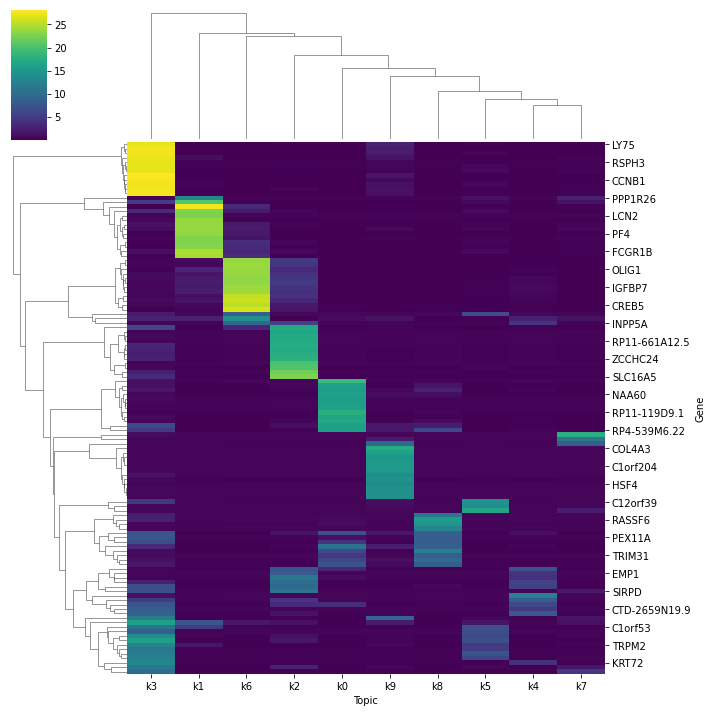

In [3]:
import _topics_util
import seaborn as sns

df_w = pd.DataFrame(B)
print(df_w.shape)
df_w.columns = sca.data.cols
df_top = _topics_util.get_topic_top_genes(df_w,top_n=12)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>10]=10
sns.clustermap(df_top.T,cmap='viridis')

In [4]:
df_gt = pd.read_csv(fn+'_scanpy_label.csv.gz')
df_join = pd.merge(df_sc,df_gt,on=['cell'],how='left')
df_join = df_join[df_join['label'].notna()]


In [5]:
df_join

,cell,tree_0,tree_1,label,umap1,umap2
0,AAACATACAACCAC-1,7,0,0.0,8.927887,3.253341
1,AAACATTGAGCTAC-1,3,8,2.0,7.016333,10.311687
2,AAACATTGATCAGC-1,3,0,0.0,10.921963,4.996583
3,AAACCGTGCTTCCG-1,8,1,1.0,-1.403201,4.500485
4,AAACCGTGTATGCG-1,8,1,5.0,11.737618,-1.013121
...,...,...,...,...,...,...
2695,TTTCGAACTCTCAT-1,8,1,1.0,0.464932,6.255583
2696,TTTCTACTGAGGCA-1,2,4,2.0,6.952725,10.245164
2697,TTTCTACTTCCTCG-1,1,9,2.0,5.122360,9.857081
2698,TTTGCATGAGAGGC-1,3,4,2.0,5.292380,11.635183


Text(0, 0.5, 'UMAP2')

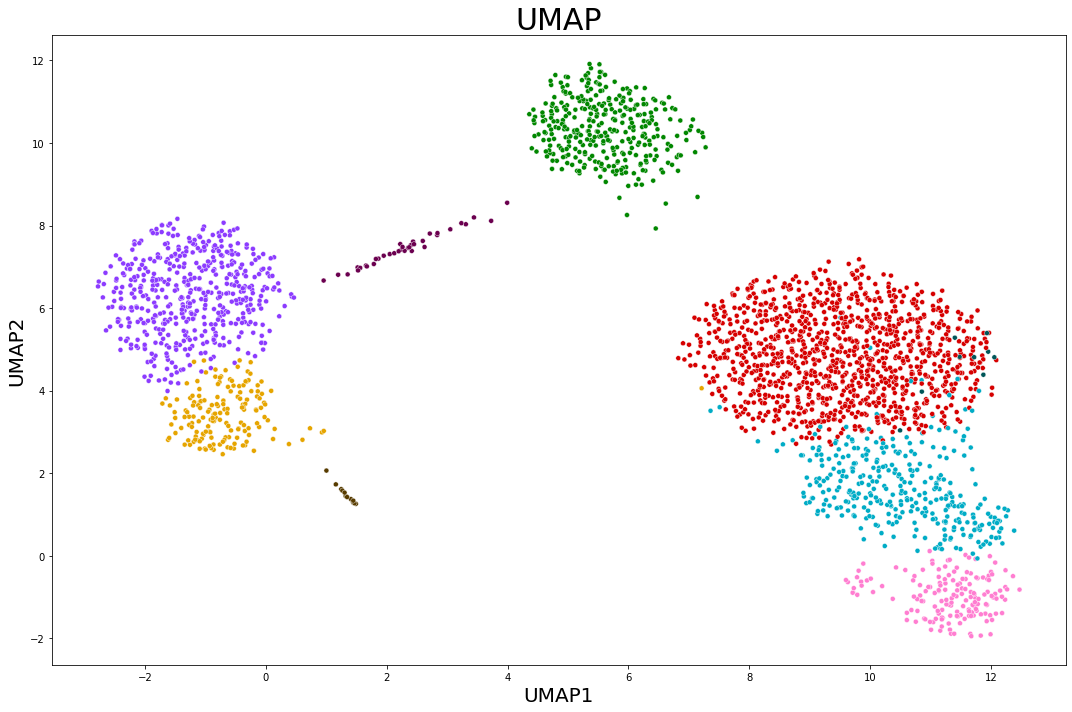

In [6]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.autolayout'] = True
import colorcet as cc
import seaborn as sns

cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_join['label'].unique()))
p = sns.scatterplot(data=df_join, x='umap1', y='umap2', hue='label',s=25,palette=cp,legend=False)
p.axes.set_title("UMAP",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

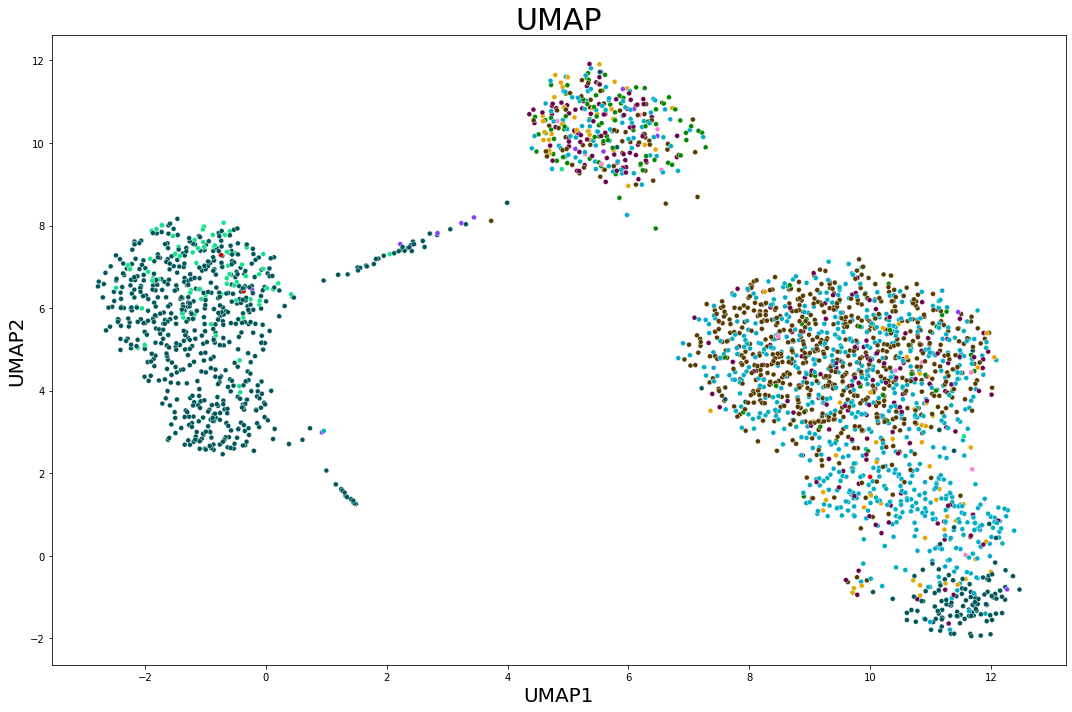

In [7]:

cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_join['tree_0'].unique()))
p = sns.scatterplot(data=df_join, x='umap1', y='umap2', hue='tree_0',s=25,palette=cp,legend=False)
p.axes.set_title("UMAP",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)





Text(0, 0.5, 'UMAP2')

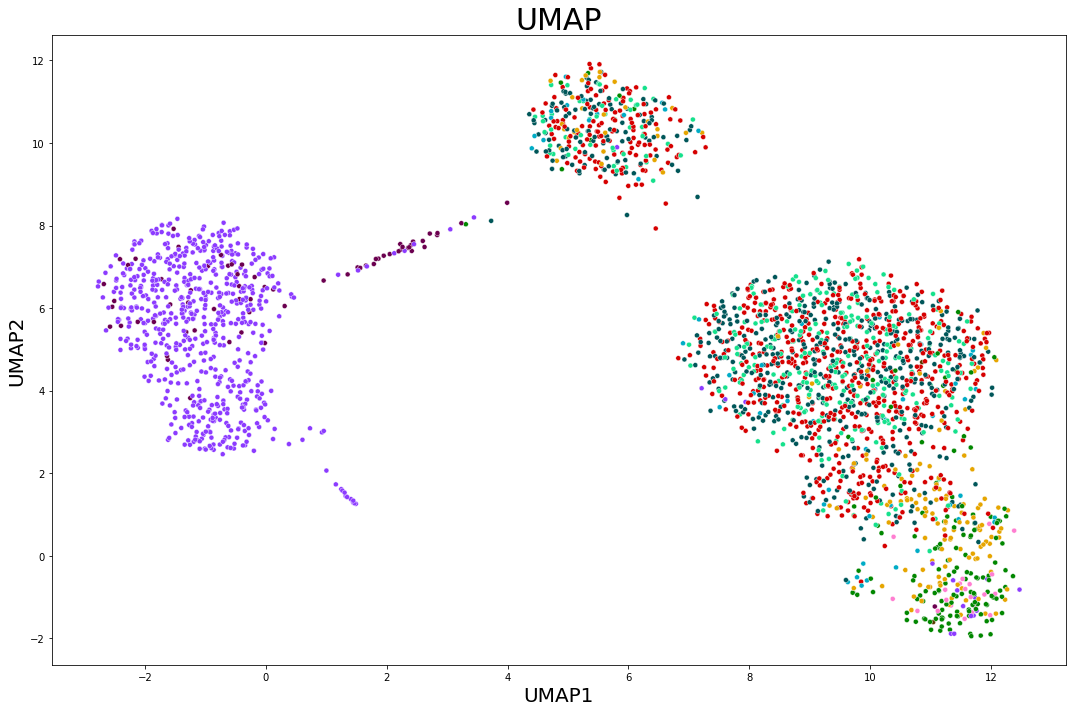

In [8]:

cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_join['tree_1'].unique()))
p = sns.scatterplot(data=df_join, x='umap1', y='umap2', hue='tree_1',s=25,palette=cp,legend=False)
p.axes.set_title("UMAP",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [9]:

cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_join['tree_2'].unique()))
p = sns.scatterplot(data=df_join, x='umap1', y='umap2', hue='tree_2',s=25,palette=cp,legend=False)
p.axes.set_title("UMAP",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

KeyError: 'tree_2'